# Sommaire

1. [Importation des packages](#Importation-des-packages)
2. [Importation des données](#Importation-des-données)
3. [Etude du jeu de données](#Etude-du-jeu-de-données)
4. [Préparation des données](#Préparation-des-données)
5. [Entraînement du modèle baseline](#Entraînement-du-modèle-baseline)
6. [Itération de la modélisation](#Itération-de-la-modélisation)

# Importation des packages

In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.tokenize import word_tokenize
from nltk.text import Text
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tanguy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Tanguy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Importation des données

In [118]:
# Lecture des données
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

# On ne garde que les 5000 premiers exemples (pour les tests)
train = train[:5000]

# On supprime la colonne 'id' qui ne nous sert pas
train = train.drop('id', axis=1)

# Affichage des données
train.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\r\nWhy the edits made under my use...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\r\nMore\r\nI can't make any real suggestions...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# Etude du jeu de données

In [119]:
# On affiche le nombre de commentaires de chaque catégorie
train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum()

toxic            503
severe_toxic      51
obscene          270
threat            20
insult           271
identity_hate     49
dtype: int64

In [134]:
# Affichage d'un commentaire aléatoire pour chaque catégorie
for column in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    sample = train[train[column] == 1]['comment_text'].sample(1)
    print(f"Commentaire pour la colonne {column} :\n\"{sample}\"\n")

Commentaire pour la colonne toxic :
"4609    I'm very upset that you've done this to me and...
Name: comment_text, dtype: object"

Commentaire pour la colonne severe_toxic :
"1465    To Blanchardb \r\n\r\nYou dumb motherfucker I ...
Name: comment_text, dtype: object"

Commentaire pour la colonne obscene :
"2620    William S Saturn is a sockpuppet \r\n\r\nHey d...
Name: comment_text, dtype: object"

Commentaire pour la colonne threat :
"4712    do go fuck off bastard\r\nDo Yyou Have a life?...
Name: comment_text, dtype: object"

Commentaire pour la colonne insult :
"4095    I swear, you're extremely stupid and oblivious...
Name: comment_text, dtype: object"

Commentaire pour la colonne identity_hate :
"4037    Niggers and their liberal friends steal everyt...
Name: comment_text, dtype: object"



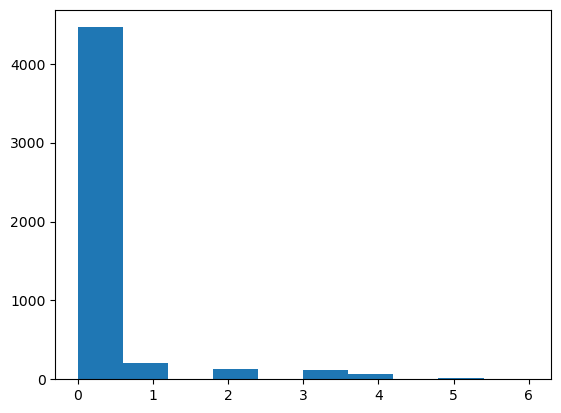

In [139]:
# Affichage du nombre de commentaires avec un certain nombre de catégories
# On voit que la plupart des commentaires sont neutres
labels = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
labels = np.sum(labels, axis=1)
plt.hist(labels)
plt.show()

# Préparation des données

In [135]:
# On met les commentaires en minuscules
train['comment_text'] = train['comment_text'].str.lower()

# Affichage des données
train.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,explanation\r\nwhy the edits made under my use...,0,0,0,0,0,0
1,d'aww! he matches this background colour i'm s...,0,0,0,0,0,0
2,"hey man, i'm really not trying to edit war. it...",0,0,0,0,0,0
3,"""\r\nmore\r\ni can't make any real suggestions...",0,0,0,0,0,0
4,"you, sir, are my hero. any chance you remember...",0,0,0,0,0,0


In [136]:
# On supprime les caractères spéciaux et on sépare les mots avec nltk
tokenizer = nltk.RegexpTokenizer(r'\w+')
train['comment_text'] = train['comment_text'].apply(tokenizer.tokenize)

# Affichage des données
train.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,"[explanation, why, the, edits, made, under, my...",0,0,0,0,0,0
1,"[d, aww, he, matches, this, background, colour...",0,0,0,0,0,0
2,"[hey, man, i, m, really, not, trying, to, edit...",0,0,0,0,0,0
3,"[more, i, can, t, make, any, real, suggestions...",0,0,0,0,0,0
4,"[you, sir, are, my, hero, any, chance, you, re...",0,0,0,0,0,0


In [137]:
# On supprime les stopwords
stopwords = nltk.corpus.stopwords.words()
train['comment_text'] = train['comment_text'].apply(lambda x: [word for word in x if word not in stopwords])

# Affichage des données
train.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,"[explanation, edits, made, username, hardcore,...",0,0,0,0,0,0
1,"[aww, matches, background, colour, seemingly, ...",0,0,0,0,0,0
2,"[hey, edit, guy, constantly, removing, relevan...",0,0,0,0,0,0
3,"[make, real, suggestions, improvement, wondere...",0,0,0,0,0,0
4,"[sir, hero, chance, remember, page]",0,0,0,0,0,0


In [140]:
# On lemmatise les mots
Word_Lemmatizer = WordNetLemmatizer()
train['comment_text'] = train['comment_text'].apply(lambda x: [Word_Lemmatizer.lemmatize(word) for word in x])

# Affichage des données
train.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,"[explanation, edits, made, username, hardcore,...",0,0,0,0,0,0
1,"[aww, match, background, colour, seemingly, st...",0,0,0,0,0,0
2,"[hey, edit, guy, constantly, removing, relevan...",0,0,0,0,0,0
3,"[make, real, suggestion, improvement, wondered...",0,0,0,0,0,0
4,"[sir, hero, chance, remember, page]",0,0,0,0,0,0


In [141]:
# Enfin, on reconstitue les phrases
sentences = list(map(lambda x : " ".join(x), train['comment_text']))

# Affichage des données
sentences[:3]

['explanation edits made username hardcore metallica reverted vandalism closure gas voted york doll fac remove template talk page retired 89 205 38 27',
 'aww match background colour seemingly stuck talk 21 51 january 11 2016 utc',
 'hey edit guy constantly removing relevant information talking edits instead talk page formatting actual info']

# Entraînement du modèle baseline

In [142]:
# Pour le premier modèle, on va utiliser un Random Forest Classifier
# Avant cela, on va vectoriser les phrases avec TF-IDF
vectorizer = TfidfVectorizer()

# On fit le vectorizer sur les phrases
vectorizer.fit(sentences)

# On transforme les phrases en vecteurs
vectors = vectorizer.transform(sentences)

# Séparation des données en train et test
train_vectors, test_vectors, train_labels, test_labels = train_test_split(vectors, labels, test_size=0.1, random_state=0)

# Affichage des dimensions des données
print(f"Train sequences shape : {train_vectors.shape}")
print(f"Test sequences shape : {test_vectors.shape}")
print(f"Train labels shape : {train_labels.shape}")
print(f"Test labels shape : {test_labels.shape}")

Train sequences shape : (4500, 21278)
Test sequences shape : (500, 21278)
Train labels shape : (4500,)
Test labels shape : (500,)


In [143]:
# Maintenant, on peut créer le modèle
model = RandomForestClassifier(n_estimators=15,random_state=0)

# Entrainement du modèle
model.fit(train_vectors, train_labels)

# Prédiction sur les données de test
predictions = model.predict(test_vectors)

# Affichage de l'accuracy
print(f"Accuracy : {accuracy_score(test_labels, predictions)}")

Accuracy : 0.918


# Itération de la modélisation

In [144]:
# Pour le deuxième modèle, on va utiliser un réseau de neurones récurrent (RNN)
# Avant cela, on va tokeniser les phrases et leur donner la même longueur

# Création du tokenizer
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(sentences)

# Récupération du vocabulaire
word_index = tokenizer.word_index
vocab_size = len(word_index)

# Tokenisation des phrases
sequences = tokenizer.texts_to_sequences(sentences)

# Padding des phrases
max_length = 200
padded = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
labels = np.array(train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values)

# Séparation des données en train et test
train_sequences, test_sequences, train_labels, test_labels = train_test_split(padded, labels, test_size=0.1, random_state=0)

# Affichage des dimensions des données
print(f"Train sequences shape : {train_sequences.shape}")
print(f"Test sequences shape : {test_sequences.shape}")
print(f"Train labels shape : {train_labels.shape}")
print(f"Test labels shape : {test_labels.shape}")

Train sequences shape : (4500, 200)
Test sequences shape : (500, 200)
Train labels shape : (4500, 6)
Test labels shape : (500, 6)


In [145]:
embedding_dim = 100

# Création du modèle
model = Sequential([
    Embedding(vocab_size+1, embedding_dim, input_length=max_length),
    LSTM(units=64),
    Dense(6, activation='sigmoid')
])

# Création de la métrique F1
f1_score = tfa.metrics.F1Score(num_classes=6, threshold=0.5)

# Compilation du modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score])

# Affichage du résumé du modèle
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 200, 100)          2158300   
                                                                 
 lstm_7 (LSTM)               (None, 64)                42240     
                                                                 
 dense_7 (Dense)             (None, 6)                 390       
                                                                 
Total params: 2,200,930
Trainable params: 2,200,930
Non-trainable params: 0
_________________________________________________________________


In [146]:
num_epochs = 3

# Entrainement du modèle
history = model.fit(train_sequences, train_labels, epochs=num_epochs, validation_data=(test_sequences, test_labels),batch_size=32)

Epoch 1/3
141/141 [==============================] - 32s 206ms/step - loss: 0.3847 - accuracy: 0.9724 - f1_score: 0.0251 - val_loss: 0.2712 - val_accuracy: 0.9920 - val_f1_score: 0.0000e+00
Epoch 2/3
141/141 [==============================] - 30s 210ms/step - loss: 0.3732 - accuracy: 0.9929 - f1_score: 0.0103 - val_loss: 0.2695 - val_accuracy: 0.9920 - val_f1_score: 0.0000e+00
Epoch 3/3
141/141 [==============================] - 23s 164ms/step - loss: 0.3723 - accuracy: 0.9922 - f1_score: 0.0468 - val_loss: 0.2694 - val_accuracy: 0.9920 - val_f1_score: 0.0000e+00


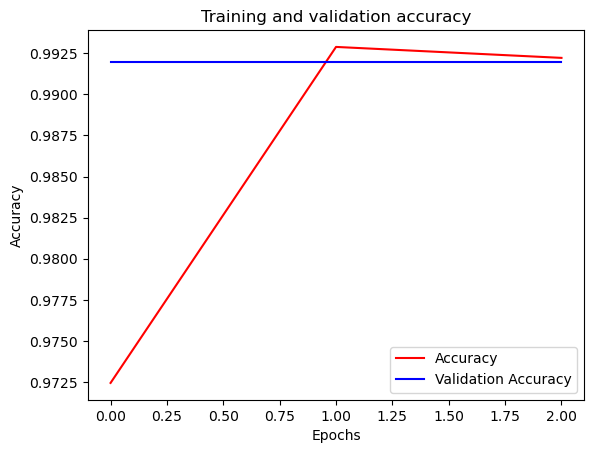

<Figure size 640x480 with 0 Axes>

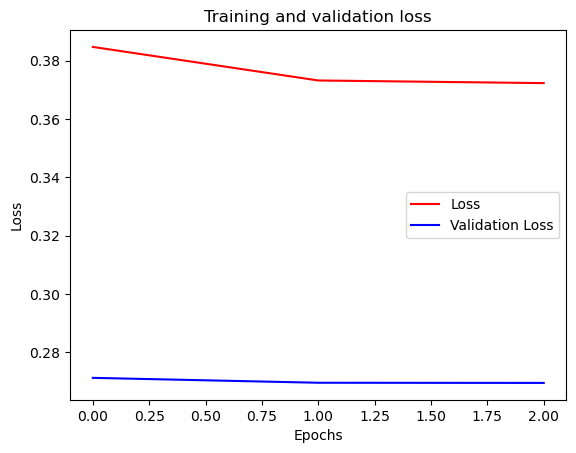

<Figure size 640x480 with 0 Axes>

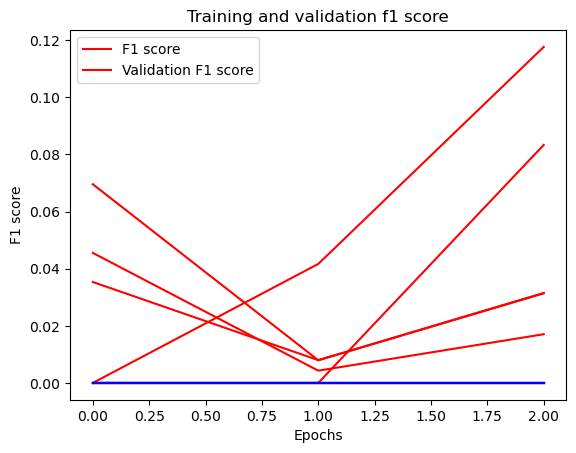

<Figure size 640x480 with 0 Axes>

In [147]:
# Affichage des courbes de métriques
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
f1_score = history.history['f1_score']
val_f1_score = history.history['val_f1_score']

epochs=range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.figure()
plt.show()

plt.plot(epochs, f1_score, 'r')
plt.plot(epochs, val_f1_score, 'b')
plt.title('Training and validation f1 score')
plt.xlabel("Epochs")
plt.ylabel("F1 score")
plt.legend(["F1 score", "Validation F1 score"])
plt.figure()
plt.show()

In [ ]:
# On peut de nouveau itérer sur le modèle pour améliorer les résultats.
# Pour cela, on va utiliser une matrice d'embedding.

embedding_dim = 100
embeddings_matrix = np.zeros((vocab_size+1, embedding_dim))

model = Sequential([
    Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    LSTM(units=64),
    Dense(6, activation='sigmoid')
])

# Print the model summary
model.summary()

# F1 score callback
f1_score = tfa.metrics.F1Score(num_classes=6, threshold=0.5)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score])

In [ ]:
# Fit the model
history = model.fit(train_sequences, train_labels, epochs=num_epochs, validation_data=(test_sequences, test_labels),batch_size=32)

In [ ]:
# Affichage des courbes de métriques
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
f1_score = history.history['f1_score']
val_f1_score = history.history['val_f1_score']

epochs=range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.figure()
plt.show()

plt.plot(epochs, f1_score, 'r')
plt.plot(epochs, val_f1_score, 'b')
plt.title('Training and validation f1 score')
plt.xlabel("Epochs")
plt.ylabel("F1 score")
plt.legend(["F1 score", "Validation F1 score"])
plt.figure()
plt.show()